### Introduction

The following notebook collates the data from original Thesis folder structure, removes repeating wildtype normal sample (fish one) and generates a hdf file for deep-learning purposes.

### Importing Libraries

In [146]:
import os
import h5py
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

### Defining Directories

In [18]:
dir_zebrafish_hdf = "/Users/katienoonan/Documents/0.01 Zebrafish Data/"
dir_zebrafish_dicom = "/Users/katienoonan/Documents/Zebrafish Work/Data/"

dir_github_repo = "/Users/katienoonan/Documents/GitHub/Zebrafish_Analysis_API/0.01 data_handling/"

### Extra Info Excel File
Excel File with information to groups of fish (mutated or not) and ages (0 - 2 Years)

In [68]:
os.chdir(dir_github_repo)

more_info_df = pd.read_csv('BMD15102021.xlsx - Sheet1.csv')
more_info_df = more_info_df[["FishName", "Age Cohort", "Group"]]

more_info_df.head()

,FishName,Age Cohort,Group
0,I20200224191953.1.dcm,Young 2,Wild Type
1,I20200224191953.2.dcm,Young 2,Wild Type
2,I20200224191953.3.dcm,Young 2,Wild Type
3,I20200224191953.4.dcm,Young 2,Wild Type
4,I20200224191953.5.dcm,Young 2,Wild Type


### Reading in DICOM Files

In [73]:
type = "spine"

os.chdir(os.path.join(dir_zebrafish_dicom, type.capitalize()))

n = len(more_info_df)

for set in os.listdir():
    samples = glob.glob(str(set) + "/*.dcm")
    samples = [samples[n].split("/")[1] for n in range(len(samples))]   # Removing Sample Folder Name
    samples = [samples[n][len(samples[n].split("_")[0]) + 1:] for n in range(len(samples))]    # Reconstructing to Standard Naming Format

    progressbar = tqdm(samples, desc = "Progress of " + str(set))
    for sample in progressbar:
        try:
            more_info_df.loc[np.where(np.array(more_info_df["FishName"]) == sample)[0][0], "Original Subset"] = set
        except:
            n += 1
            more_info_df["Original Subset"][n] = set
            more_info_df["FishName"][n] = sample



Progress of Training:   9%|▉         | 58/612 [00:00<00:01, 449.46it/s]

Progress of Validation: 100%|██████████| 100/100 [00:00<00:00, 388.02it/s]


### Getting Sample Names

In [139]:
os.chdir(os.path.join(dir_zebrafish_dicom, "Individual Dicom Samples"))

sample_list = []

for set in os.listdir():
    samples = glob.glob(str(set) + "/*.dcm")
    samples = [samples[n].split("/")[1] for n in range(len(samples))]  # Removing Sample Folder Name
    # samples = [samples[n][len(samples[n].split("_")[0]) + 1:] for n in range(len(samples))]    # Reconstructing to Standard Naming Format

    sample_list.extend(samples)

# sample_list = np.array(sample_list)

len(sample_list)

812

Removing repeating reference sample and keeping only one random sample

In [140]:
repeat_reference = [np.array(sample_list)[n].split(".")[1] for n in range(len(sample_list))]
repeat_reference = np.where(np.array(repeat_reference) == "1")[0]

repeat_reference = np.delete(repeat_reference, np.random.choice(repeat_reference))
len(repeat_reference)

171

In [141]:
sample_list = np.delete(np.array(sample_list), repeat_reference)
len(sample_list)

641

### Splitting into 70/10/20 Sets for Training, Testing and Validation

Progress:   0%|          | 0/641 [00:00<?, ?it/s]

Progress: 100%|██████████| 641/641 [00:00<00:00, 1488.33it/s]


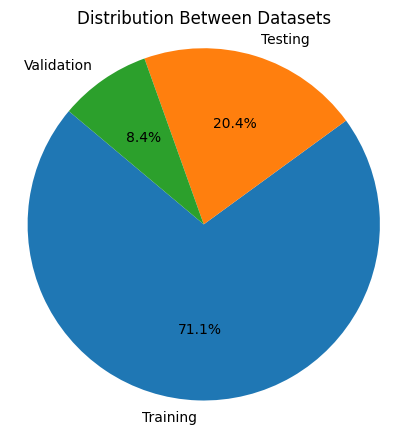

In [156]:
dataframe = pd.DataFrame(columns=["Input Name", "Subset"])

dataframe["Input Name"] = sample_list

progressbar = tqdm(sample_list, desc = "Progress", leave = True)
for sample in progressbar:
    variable = np.random.randint(0, 100)

    if variable <= 70:
        dataframe.loc[np.where(dataframe["Input Name"] == sample)[0][0], "Subset"] = "Training"

    elif variable > 70 and variable <= 90:
        dataframe.loc[np.where(dataframe["Input Name"] == sample)[0][0], "Subset"] = "Testing"

    else:
        dataframe.loc[np.where(dataframe["Input Name"] == sample)[0][0], "Subset"] = "Validation"

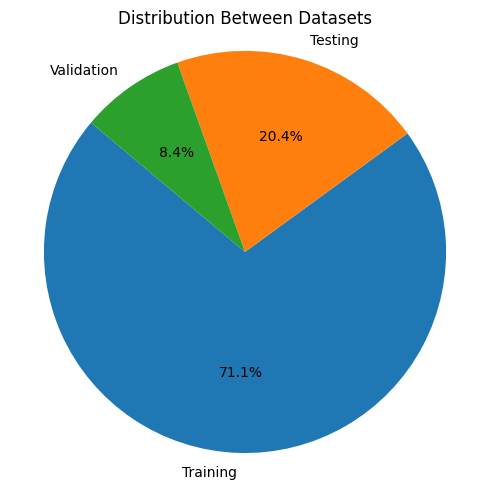

In [161]:
os.chdir(dir_github_repo)

fig = plt.figure(figsize = (5, 5))

plt.pie(dataframe["Subset"].value_counts(), labels = dataframe["Subset"].value_counts().index, 
        autopct = '%1.1f%%', startangle = 140)
plt.axis('equal')
plt.title("Distribution Between Datasets")

fig.tight_layout()
plt.savefig("Distribution")
plt.show()

dataframe.to_excel("dataset_split.xlsx", index = False)

### Generating HDF

In [8]:
os.chdir(dir_zebrafish_hdf)

hdf = h5py.File("zebrafish_modelling_data_v1.hdf", "w")

hdf.close()